<a href="https://colab.research.google.com/github/jihun0423/NLP/blob/main/IMDB_movie_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 030. 영화평 Text 분류 - Sentiment Analysis

- IMDB (Internet Movie Database, https://www.imdb.com/)  Dataset


- 각 25,000 개의 training/testing set 으로 구성된 IMDB 영화관람평  


- “imdb_reviews” – encoding 되어있지 않은 string 형태의 data  


- label : positive, negative binary classification

## imdb_reviews (string data) 이용

In [1]:
 import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

train_dataset, test_dataset = dataset['train'], dataset['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteK5GUXI/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteK5GUXI/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteK5GUXI/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
len(train_dataset), len(test_dataset)

(25000, 25000)

In [4]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir=PosixGPath('/tmp/tmp3o2kibictfds'),
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
        'train': <SplitInfo

### tfds 는 tf.Tensor 반환

In [7]:
for input, label in dataset['test']:
    print(label)
    print(input)
    break

tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.", shape=(), 

## keras.preprocessing module 을 이용하여 tokenize 및 padding
- keras.preprocessing.text.Tokenizer  

- keras.preprocessing.sequence.pad_sequence

In [8]:
train_sentences = []
train_labels = []
test_sentences = []
test_labels = []

for sent, label in train_dataset:
    train_sentences.append(str(sent.numpy()))
    train_labels.append(label.numpy())

for sent, label in test_dataset:
    test_sentences.append(str(sent.numpy()))
    test_labels.append(label.numpy())

print(train_labels[-1])
print(train_sentences[-1])

print(test_labels[-1])
print(test_sentences[-1])

1
b'First of all, Riget is wonderful. Good comedy and mystery thriller at the same time. Nice combination of strange \'dogma\' style of telling the story together with good music and great actors. But unfortunately there\'s no \'the end\'. As for me it\'s unacceptable. I was thinking... how it will be possible to continue the story without Helmer and Drusse? ...and I have some idea. I think Lars should make RIGET III a little bit different. I\'m sure that 3rd part without Helmer wouldn\'t be the same. So here\'s my suggestion. Mayble little bit stupid, maybe not. I know that Lars likes to experiment. So why not to make small experiment with Riget3? I think the only solution here is to create puppet-driven animation (like for example "team America" by Trey Parker) or even computer 3d animation. I know it\'s not the same as real actors, but in principle I believe it could work... only this way it\'s possible to make actors alive again. For Riget fans this shouldn\'t be so big difference 

## train_labels, test_labels  list를 numpy array 로 변환

In [9]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

print(train_labels.shape)
print(test_labels.shape)

(25000,)
(25000,)


## train_sentences, test_sentences text 를 sequence 로 변환

In [10]:
vocab_size = 10000

tokenizer = Tokenizer(num_words = vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(train_sentences)

In [11]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

print(train_sequences[0])
print(test_sequences[0])

[59, 12, 14, 35, 439, 400, 18, 174, 29, 1, 9, 33, 1378, 3401, 42, 496, 1, 197, 25, 88, 156, 19, 12, 211, 340, 29, 70, 248, 213, 9, 486, 62, 70, 88, 116, 99, 24, 5740, 12, 3317, 657, 777, 12, 18, 7, 35, 406, 8228, 178, 2477, 426, 2, 92, 1253, 140, 72, 149, 55, 2, 1, 7525, 72, 229, 70, 2962, 16, 1, 2880, 1, 1, 1506, 4998, 3, 40, 3947, 119, 1608, 17, 3401, 14, 163, 19, 4, 1253, 927, 7986, 9, 4, 18, 13, 14, 4200, 5, 102, 148, 1237, 11, 240, 692, 13, 44, 25, 101, 39, 12, 7232, 1, 39, 1378, 1, 52, 409, 11, 99, 1214, 874, 145, 10]
[59, 44, 25, 109, 13, 97, 4115, 16, 742, 4370, 10, 14, 316, 5, 2, 593, 354, 16, 1864, 1212, 1, 16, 680, 7499, 5595, 1, 773, 6, 13, 1037, 1, 1, 439, 491, 1, 4, 1, 334, 3610, 20, 229, 3, 15, 5796, 3, 15, 1646, 15, 102, 5, 2, 3597, 101, 11, 1450, 1528, 12, 251, 235, 11, 216, 2, 377, 6429, 3, 62, 95, 11, 174, 105, 11, 1528, 180, 12, 251, 37, 6, 1144, 1, 682, 7, 4452, 1, 4, 1, 334, 7, 37, 8367, 377, 5, 1420, 1, 13, 30, 64, 28, 6, 874, 181, 17, 4, 1050, 5, 12, 224, 3, 83,

In [22]:
word_count_dic = list(sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True))[:50]

In [23]:
word_count_dic

[('the', 335336),
 ('and', 164071),
 ('a', 162690),
 ('of', 145835),
 ('to', 135660),
 ('is', 107300),
 ('br', 101872),
 ('in', 93724),
 ('it', 88489),
 ('i', 80280),
 ('this', 74144),
 ('that', 71820),
 ('was', 48191),
 ('as', 46769),
 ('for', 44252),
 ('with', 44084),
 ('movie', 43847),
 ('but', 42587),
 ('film', 39748),
 ("'s", 37123),
 ('on', 34168),
 ('you', 32257),
 ('not', 30564),
 ('are', 29420),
 ('his', 29366),
 ('he', 28925),
 ('have', 27718),
 ('be', 26948),
 ('one', 26560),
 ('all', 23939),
 ('at', 23481),
 ('by', 22524),
 ('they', 22204),
 ('an', 21473),
 ('who', 21069),
 ('so', 20544),
 ('from', 20458),
 ('like', 20247),
 ('her', 18414),
 ("'t", 18280),
 ('or', 17991),
 ('just', 17701),
 ('there', 17367),
 ('about', 17366),
 ('out', 17093),
 ("'", 16952),
 ('has', 16786),
 ('if', 16596),
 ('some', 15706),
 ('what', 15665)]

In [15]:
sum([x for _,x in tokenizer.word_counts.items()])

6047798

In [66]:
import pandas as pd
train_df =pd.DataFrame({'sentences':train_sentences})
test_df = pd.DataFrame({'sentences':test_sentences})

In [67]:
# 특수 문자 제거
train_df['clean_doc'] = train_df['sentences'].str.replace("[^a-zA-Z]", " ")
# 길이가 3이하인 단어는 제거 (길이가 짧은 단어 제거)
train_df['clean_doc'] = train_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# 전체 단어에 대한 소문자 변환
train_df['clean_doc'] = train_df['clean_doc'].apply(lambda x: x.lower())

<ipython-input-67-50e8e6b62c4d>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_df['clean_doc'] = train_df['sentences'].str.replace("[^a-zA-Z]", " ")


In [68]:
# 특수 문자 제거
test_df['clean_doc'] = test_df['sentences'].str.replace("[^a-zA-Z]", " ")
# 길이가 3이하인 단어는 제거 (길이가 짧은 단어 제거)
test_df['clean_doc'] = test_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# 전체 단어에 대한 소문자 변환
test_df['clean_doc'] = test_df['clean_doc'].apply(lambda x: x.lower())

<ipython-input-68-a79e88e76992>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_df['clean_doc'] = test_df['sentences'].str.replace("[^a-zA-Z]", " ")


In [69]:
train_df.head(3)

,sentences,clean_doc
0,"b""This was an absolutely terrible movie. Don't...",this absolutely terrible movie lured christoph...
1,b'I have been known to fall asleep during film...,have been known fall asleep during films this ...
2,b'Mann photographs the Alberta Rocky Mountains...,mann photographs alberta rocky mountains super...


In [70]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

stop_words = stopwords.words('english')  # 불용어
tokenized_doc = train_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [71]:
stop_words = stopwords.words('english')  # 불용어
tokenized_doc_test = test_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc_test = tokenized_doc_test.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc_test = tokenized_doc_test.to_list()

In [43]:
# 단어가 1개 이하인 샘플의 인덱스를 찾아서 저장하고, 해당 샘플들은 제거.
drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) <= 1]
tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)
print('총 샘플 수 :',len(tokenized_doc))

총 샘플 수 : 25000


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [72]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
idx2word = {value : key for key, value in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

In [73]:
encoded_test = tokenizer.texts_to_sequences(tokenized_doc_test)

In [46]:
word_count_dic = list(sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True))[:50]
word_count_dic

[('movie', 44047),
 ('film', 40162),
 ('like', 20281),
 ('good', 15147),
 ('time', 12727),
 ('even', 12656),
 ('would', 12436),
 ('story', 11990),
 ('really', 11739),
 ('well', 10668),
 ('much', 9766),
 ('people', 9287),
 ('also', 9158),
 ('first', 9063),
 ('great', 9061),
 ('made', 8364),
 ('make', 8025),
 ('could', 7923),
 ('movies', 7668),
 ('think', 7298),
 ('characters', 7159),
 ('character', 7024),
 ('watch', 6974),
 ('films', 6889),
 ('seen', 6681),
 ('many', 6675),
 ('life', 6632),
 ('plot', 6589),
 ('acting', 6493),
 ('never', 6485),
 ('love', 6454),
 ('little', 6437),
 ('best', 6416),
 ('show', 6295),
 ('know', 6167),
 ('ever', 5998),
 ('better', 5740),
 ('still', 5624),
 ('scene', 5383),
 ('scenes', 5213),
 ('something', 5077),
 ('back', 4972),
 ('real', 4738),
 ('watching', 4606),
 ('though', 4566),
 ('thing', 4529),
 ('years', 4516),
 ('actors', 4488),
 ('director', 4449),
 ('work', 4374)]

In [55]:
sum([x for _,x in tokenizer.word_counts.items()])

2704588

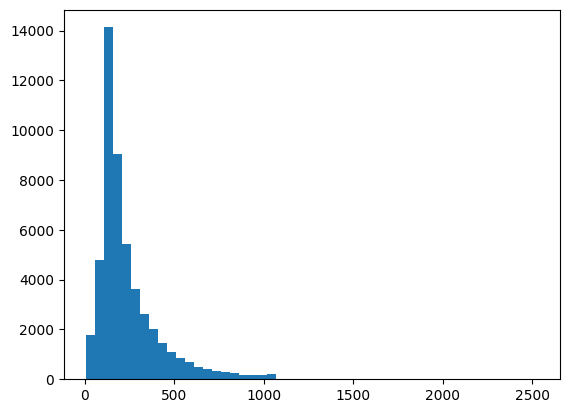

In [47]:
plt.hist([len(s) for s in train_sequences] + [len(s) for s in test_sequences], bins=50);

In [ ]:
max_length = 150

train_padded = pad_sequences(train_sequences,maxlen=max_length, truncating='post', padding='post')

test_padded = pad_sequences(test_sequences,maxlen=max_length, truncating='post', padding='post')

print(train_padded.shape)
print(test_padded.shape)
print(train_padded[0])
print(test_padded[0])

(25000, 150)
(25000, 150)
[  59   12   14   35  439  400   18  174   29    1    9   33 1378 3401
   42  496    1  197   25   88  156   19   12  211  340   29   70  248
  213    9  486   62   70   88  116   99   24 5740   12 3317  657  777
   12   18    7   35  406 8228  178 2477  426    2   92 1253  140   72
  149   55    2    1 7525   72  229   70 2962   16    1 2880    1    1
 1506 4998    3   40 3947  119 1608   17 3401   14  163   19    4 1253
  927 7986    9    4   18   13   14 4200    5  102  148 1237   11  240
  692   13   44   25  101   39   12 7232    1   39 1378    1   52  409
   11   99 1214  874  145   10    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
[  59   44   25  109   13   97 4115   16  742 4370   10   14  316    5
    2  593  354   16 1864 1212    1   16  680 7499 5595    1  773    6
   13 1037    1    1  439  491    1    4    1  334 3610   20  229    3

In [74]:
max_length = 150

train_padded = pad_sequences(encoded,maxlen=max_length, truncating='post', padding='post')

test_padded = pad_sequences(encoded_test,maxlen=max_length, truncating='post', padding='post')

print(train_padded.shape)
print(test_padded.shape)
print(train_padded[0])
print(test_padded[0])

(25000, 150)
(25000, 150)
[ 264  232    2 9728 1090 2863  300 9946   16   49   84  181  114   91
  301    7   16   30   19 5132    2  447  558    2  236 7369 2113  253
  966   41    1 6814  100 2560    1 2412    1    1 1212 4422 3478   32
 1297 2863   53  966  691 7248    2 3702   44  957  488   20    4 6440
  132    4 1090 2863    5  237   19  938    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
[  25   18 3636  520 3369  163  390  189 1536  916 9997  463 6796    1
  779    1    1  264  306    1    1  178 3160    3  100 5181 1339 3147
   20 1219  116  106  208 5561    7   21 1219   64  116  866    1  474

- sequence data 를 sentence 로 reverse conversion

In [77]:
reverse_word_index = dict([(value, key) for (key, value) in tokenizer.word_index.items()])

def decode_review(sequence):
    return ' '.join([tokenizer.index_word.get(i, '<pad>') for i in sequence])

print(decode_review(train_padded[0]))
print()
print(train_df['sentences'][0])

absolutely terrible movie lured christopher walken michael ironside great actors must simply worst role history even great acting could redeem movie ridiculous storyline movie early nineties propaganda piece pathetic scenes <OOV> rebels making cases <OOV> maria <OOV> <OOV> appeared phony pseudo love affair walken nothing pathetic emotional plug movie devoid real meaning disappointed movies like ruining actor like christopher walken good name could barely <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

b"This was an absolutely

## model define

In [78]:
model = Sequential([
    Embedding(vocab_size+1, 64),
    Bidirectional(tf.keras.layers.LSTM(64)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          640064    
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 714433 (2.73 MB)
Trainable params: 714433 (2.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [79]:
%%time
num_epochs = 30
history = model.fit(train_padded, train_labels, epochs=num_epochs, batch_size=128,
                validation_data=(test_padded, test_labels), verbose=1)

Epoch 1/30
196/196 [==============================] - 50s 208ms/step - loss: 0.4157 - accuracy: 0.7989 - val_loss: 0.3458 - val_accuracy: 0.8583
Epoch 2/30
196/196 [==============================] - 27s 139ms/step - loss: 0.2213 - accuracy: 0.9161 - val_loss: 0.3589 - val_accuracy: 0.8548
Epoch 3/30
196/196 [==============================] - 19s 95ms/step - loss: 0.1602 - accuracy: 0.9427 - val_loss: 0.3972 - val_accuracy: 0.8386
Epoch 4/30
196/196 [==============================] - 18s 94ms/step - loss: 0.1235 - accuracy: 0.9569 - val_loss: 0.4714 - val_accuracy: 0.8430
Epoch 5/30
196/196 [==============================] - 11s 58ms/step - loss: 0.0977 - accuracy: 0.9668 - val_loss: 0.5683 - val_accuracy: 0.8415
Epoch 6/30
196/196 [==============================] - 9s 47ms/step - loss: 0.0691 - accuracy: 0.9784 - val_loss: 0.6403 - val_accuracy: 0.8181
Epoch 7/30
196/196 [==============================] - 7s 36ms/step - loss: 0.0668 - accuracy: 0.9783 - val_loss: 0.6919 - val_accuracy:

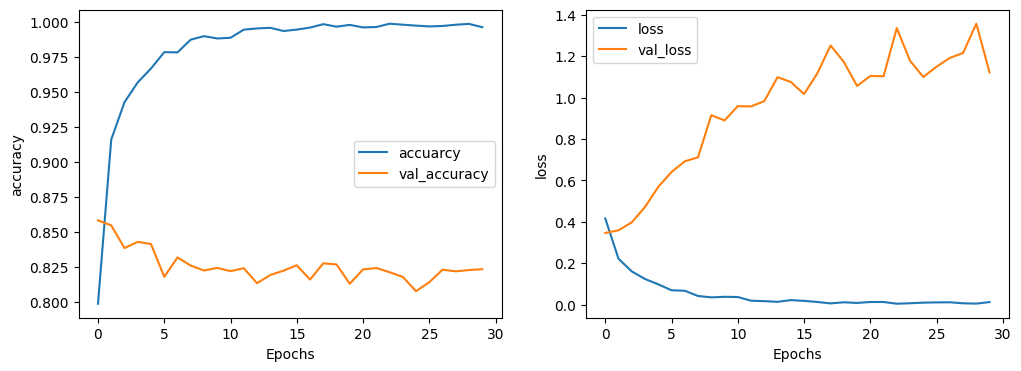

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('Epochs')
ax1.set_ylabel('accuracy')
ax1.legend(['accuarcy', 'val_accuracy'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('Epochs')
ax2.set_ylabel('loss')
ax2.legend(['loss', 'val_loss'])
plt.show()

In [102]:
sample_text = ['The movie was terrible. I would not recommend the movie',
               'I really love this movie! It was fantastic/1',
               'I think the director was out of his mind. Such a bad movie',
               'The movie was fantastic. I would recommend the movie',
               'The animation and graphics were out of this world']
sample_seq = tokenizer.texts_to_sequences(sample_text)
sample_padded = pad_sequences(sample_seq, maxlen=max_length, padding='post', truncating='post')
sample_padded

array([[   1,    2,    1,  232,    1,    8,    1,  224,    1,    2,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [103]:
sample_labels = pd.DataFrame({'labels':[0,1,0,1,1]})

In [104]:
pred=model.predict([sample_padded])

1/1 [==============================] - 0s 25ms/step


In [107]:
sample_labels['predicted'] = pred

In [108]:
sample_labels['predicted_label'] = (pred>0.5)*1

In [109]:
sample_labels

,labels,predicted,predicted_label
0,0,0.016168,0
1,1,0.748337,1
2,0,0.145442,0
3,1,0.375470,0
4,1,0.927352,1
